In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [92]:
df = pd.read_csv('Data for ML - Sheet1.csv')
df.head()

,station,year,month,day,avg_wind_speed,max_wind_gust,avg_wind_dir,max_air_temp,avg_air_temp,sol_rad,...,avg_soil_temp_4in_sod,max_soil_temp_8in_sod,min_soil_temp_8in_sod,avg_soil_temp_8in_sod,max_soil_temp_4in_bare,min_soil_temp_4in_bare,avg_soil_temp_4in_bare,max_soil_temp_2in_bare,min_soil_temp_2in_bare,avg_soil_temp_2in_bare
0,Belleville,2022,1,1,153.4,22.0,29.6,86.0,0.01,22.4,...,48.1,50.4,47.1,49.0,53.7,42.3,47.6,55.2,38.9,46.1
1,Belleville,2022,1,2,301.9,21.1,14.9,71.2,0.02,7.7,...,41.7,47.1,41.8,44.2,42.3,35.1,37.5,38.9,32.2,34.4
2,Belleville,2022,1,3,190.5,15.1,20.2,59.5,0.02,6,...,38.4,41.8,39.7,40.4,35.1,33.5,33.9,32.2,29.8,31.5
3,Belleville,2022,1,4,167.3,24.2,31.9,75.0,0.03,24.5,...,37.9,39.7,38.8,39.2,33.9,33.3,33.5,32.1,30.2,31.5
4,Belleville,2022,1,5,276.9,37.1,32.3,65.6,0.02,12.9,...,38.0,39.7,39.1,39.3,34.0,33.6,33.8,32.5,32.0,32.2


In [93]:
soil_columns = [col for col in df.columns if 'soil' in col]

# Determine which soil columns to drop (all except 'avg_soil_temp_8in_sod')
cols_to_drop = [col for col in soil_columns if col != 'avg_soil_temp_8in_sod']
cols_to_drop += ['station', 'year', 'month', 'day']
# Create a tailored DataFrame by dropping the undesired soil columns
df_tailored = df.drop(columns=cols_to_drop)
print(df_tailored.head())

   avg_wind_speed  max_wind_gust  avg_wind_dir  max_air_temp  avg_air_temp  \
0           153.4           22.0          29.6          86.0          0.01   
1           301.9           21.1          14.9          71.2          0.02   
2           190.5           15.1          20.2          59.5          0.02   
3           167.3           24.2          31.9          75.0          0.03   
4           276.9           37.1          32.3          65.6          0.02   

  sol_rad  precip  pot_evapot  max_rel_hum  min_rel_hum  avg_soil_temp_8in_sod  
0    22.4    33.0        32.9         35.4         35.7                   49.0  
1     7.7    33.0        33.0         34.8         35.2                   44.2  
2       6    32.9        32.8         34.2         34.6                   40.4  
3    24.5    32.8        32.8         34.0         34.1                   39.2  
4    12.9    32.8        32.7         33.7         33.8                   39.3  


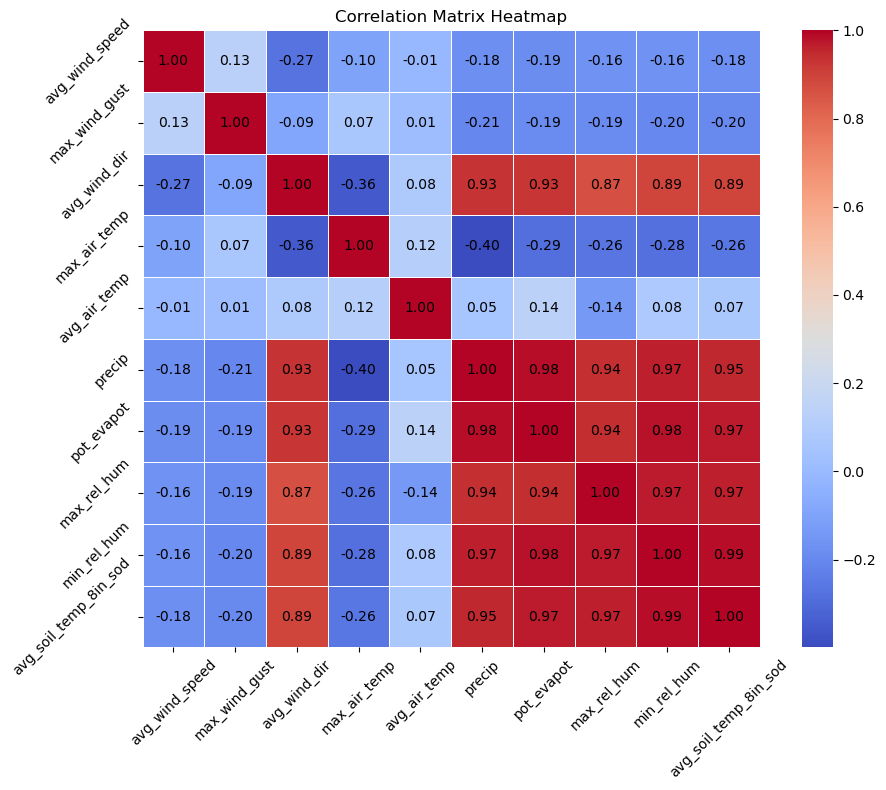

In [94]:
numeric_cols = df_tailored.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix,
                 cmap='coolwarm',
                 fmt=".2f",
                 linewidths=0.5,
                 square=True,
                 cbar=True)

# Loop over the data and create text annotations.
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        text = f"{corr_matrix.iloc[i, j]:.2f}"
        ax.text(j + 0.5, i + 0.5, text,
                ha="center", va="center", color="black", fontsize=10)

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

we choose avg_wind_dir, precip, pot_evapot, min_rel_hum as our predictor variables.

C:\Users\54206\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\54206\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


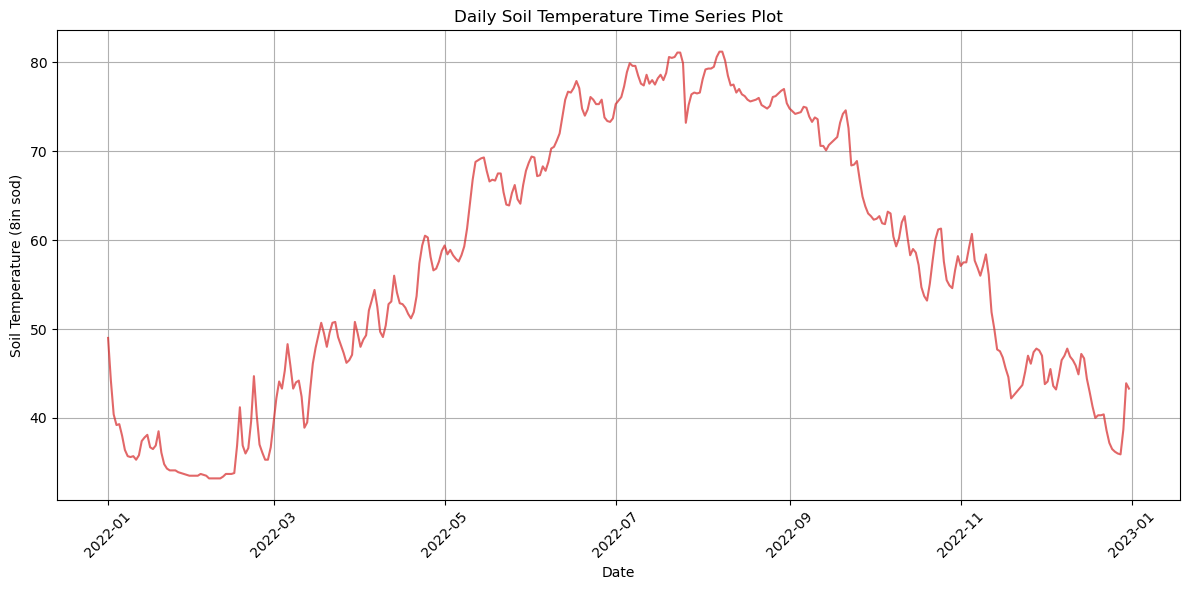

In [95]:
if df.index.name == 'date':
    df = df.reset_index()

# Create a datetime column from 'year', 'month', and 'day'
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Sort the DataFrame by date and set 'date' as the index
df = df.sort_values('date')
df.set_index('date', inplace=True)

# Convert to daily frequency; if some days are missing, they become NaN
df = df.asfreq('D')

# Remove rows with missing values in 'avg_soil_temp_8in_sod'
df = df.dropna(subset=['avg_soil_temp_8in_sod'])

# Remove any duplicate dates (if they exist)
df = df[~df.index.duplicated(keep='first')]

# Plot the time series for avg_soil_temp_8in_sod
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['avg_soil_temp_8in_sod'], color='tab:red', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Soil Temperature (8in sod)")
plt.title("Daily Soil Temperature Time Series Plot")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

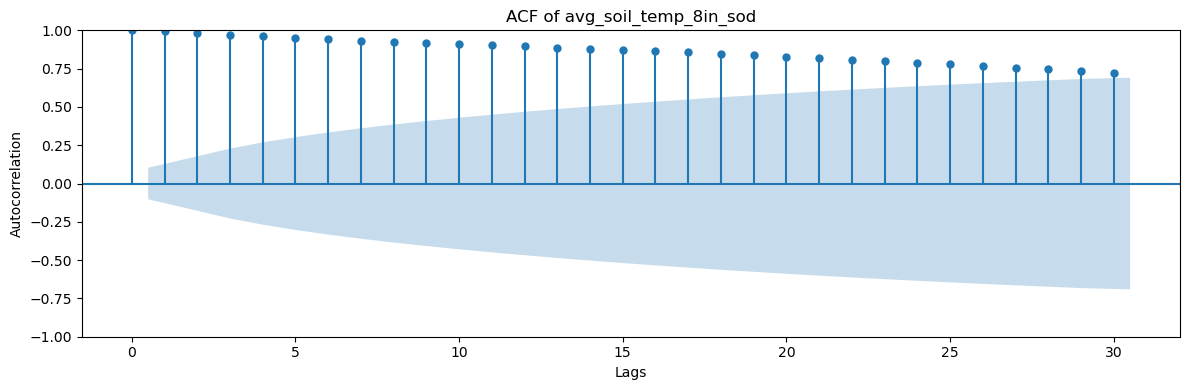

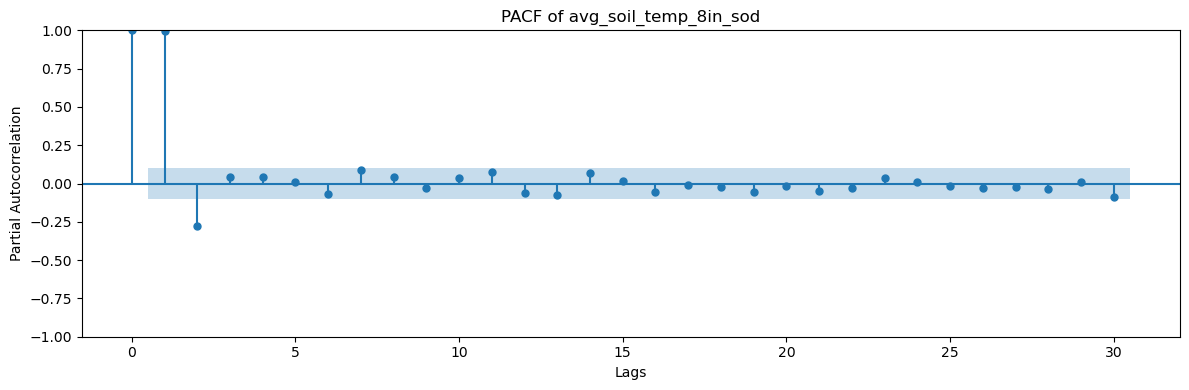

In [96]:
y = df['avg_soil_temp_8in_sod']

# 5. Plot ACF
plt.figure(figsize=(12, 4))
sm.graphics.tsa.plot_acf(y, lags=30, ax=plt.gca())
plt.title("ACF of avg_soil_temp_8in_sod")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

# 6. Plot PACF
plt.figure(figsize=(12, 4))
sm.graphics.tsa.plot_pacf(y, lags=30, ax=plt.gca(), method='ywm')
plt.title("PACF of avg_soil_temp_8in_sod")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.tight_layout()
plt.show()

The best lag at 2

In [97]:
best_lag =2
for lag in range(1, best_lag + 1):
    df[f'Tlag_{lag}'] = y.shift(lag)
    df.dropna(inplace=True)

In [102]:
X = df[['avg_wind_dir', 
             'precip', 
             'pot_evapot', 
             'min_rel_hum',
             'Tlag_1',
             'Tlag_2']]
Y = df[['avg_soil_temp_8in_sod']]
X = sm.add_constant(X)
y = y.loc[X.index]

In [107]:
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Generate polynomial features (degree 2 includes quadratic and interaction terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit a linear regression model on the polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_poly)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print the evaluation metrics with high precision
print("Evaluation Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"MAPE: {mape:.3f}")

Evaluation Metrics:
MSE: 1.191
RMSE: 1.091
MAE: 0.710
MAPE: 0.015


In [111]:
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_poly, y_train)

print("Best alpha selected:", lasso_cv.alpha_)
y_pred = lasso_cv.predict(X_test_poly)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print the evaluation metrics with high precision
print("Evaluation Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"MAPE: {mape:.3f}")

Best alpha selected: 43.55349976779514
Evaluation Metrics:
MSE: 3.470
RMSE: 1.863
MAE: 1.566
MAPE: 0.034


In [114]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print the evaluation metrics with high precision
print("Evaluation Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"MAPE: {mape:.3f}")

Evaluation Metrics:
MSE: 1.488
RMSE: 1.220
MAE: 0.860
MAPE: 0.017


| Model                        |   MSE  |  RMSE  |  MAE  |  MAPE  |
|------------------------------|--------|--------|-------|--------|
Polynomial Regression or       | 1.191  | 1.091  | 0.710 | 0.015  |Gradient Boosting Regression    | 1.488  | 1.220  | 0.860 | 0.017  |
| Lasso Polynomial Regression  | 3.470  | 1.863  | 1.566 | 0.034  |

In [115]:
# Define predictors and target variable from your DataFrame
X = df[['avg_wind_dir', 'precip', 'pot_evapot', 'min_rel_hum', 'Tlag_1', 'Tlag_2']]
y = df['avg_soil_temp_8in_sod']

# Generate quadratic (degree 2) polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model on the entire dataset
model = LinearRegression()
model.fit(X_poly, y)

# Predict the soil temperature for the entire year
df['predicted_soil_temp'] = model.predict(X_poly)

# Function to map month to season
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Create a 'season' column by mapping the month from the datetime index
df['season'] = df.index.month.map(month_to_season)

# Group predictions by season and compute the average predicted soil temperature
seasonal_avg = df.groupby('season')['predicted_soil_temp'].mean()

print("Seasonal Average Predicted Soil Temperature:")
print(seasonal_avg)

Seasonal Average Predicted Soil Temperature:
season
Fall      60.757891
Spring    54.842481
Summer    76.129921
Winter    38.160734
Name: predicted_soil_temp, dtype: float64
